In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("py")

import w8_estimation as est 
import w8_LinearModel as lm
import w8_probit as probit
import w8_logit as logit


## Read data and preliminary data selection

In [4]:
data = pd.read_csv('ppcs_cc.csv')

assert data.notnull().all().all()

print(f'All years are the same: \t{(data['year'] == 2011).all()}') # all variables are for the same year -> drop year as feature

print(f'Dummy trap in officer race: \t{data['omajother'].sum() + data['omajwhite'].sum() + data['omajhisp'].sum() + data['omajblack'].sum() == len(data)}')  # one-hot encoded -> drop one category to avoid multicollinearity

print(f'Dummy trap in civilian race: \t{data['sother'].sum() + data['swhite'].sum() + data['shisp'].sum() + data['sblack'].sum() == len(data)}')  # one-hot encoded -> drop one category to avoid multicollinearity

print(f'osplit is 0 for all obs: \t{data['osplit'].sum() == 0}')  # no variation -> drop feature

All years are the same: 	True
Dummy trap in officer race: 	True
Dummy trap in civilian race: 	True
osplit is 0 for all obs: 	True


In [5]:
pd.DataFrame({
    "mean": data.mean(),
    "sum": data.sum()
    }).round(2)

,mean,sum
sblack,0.11,420
shisp,0.10,386
swhite,0.74,2808
sother,0.05,185
smale,0.53,2012
sage,41.01,155797
sempl,0.70,2642
sincome,2.16,8224
spop,1.36,5177
daytime,0.67,2532


## Data selection

In [6]:
# types of features
x_labels = ['sblack', # dummy
 'shisp', # dummy
 'swhite', # dummy
 #'sother', # dummy -> dropped because of dummy trap: see earlier
 'smale', # dummy
 'sage', # continuous / categorical
 'sempl', # dummy
 'sincome', # categorical with numerical interpretation 
 'spop', # categorical with numerical interpretation 
 'daytime', # categorical, non-numerical interpretation
 'inctype_lin', # categorical / dummy?
 #'omajblack', # dummy -> collaped with omajhisp for union dummy to avoid seperation
 #'omajhisp', # dummy -> collaped with omajblack for union dummy to avoid seperation
 'omajwhite', # dummy
 #'omajother', # dummy -> dropped because of dummy trap: see earlier
 #'osplit', # invariant -> dropped
 #'year' # invariant -> dropped
 'sbehavior', # dummy
 ]

data['omajblackhisp'] = data['omajblack'] + data['omajhisp']
x_labels += ['omajblackhisp']

y_label = 'anyuseofforce_coded'

# list of variables to scale or square
scales = ['sage']
squares = []

# square
for var in squares:
    sq_label = var + 'sq'
    data[sq_label] = data[var]**2
    x_labels += [sq_label]

# scale
for var in scales:
    #data[var] = (data[var] - data[var].mean())/data[var].std() # standardization
    data[var] = data[var]/10 # divide by 10 scaling

In [7]:
y = data[y_label]
x = data[x_labels]

In [8]:
y = y.values
x = x.values

In [9]:
assert np.linalg.matrix_rank(x.T @ x) == x.shape[1]  # check for multicollinearity

## Intensive margin: Events with force

In [10]:
data[x_labels][data['anyuseofforce_coded'] == 1]

,sblack,shisp,swhite,smale,sage,sempl,sincome,spop,daytime,inctype_lin,omajwhite,sbehavior,omajblackhisp
6,1,0,0,1,2.8,0,1,4,1,1,1,1,0
70,0,1,0,1,3.0,1,1,4,0,2,1,1,0
354,1,0,0,1,4.0,0,3,2,1,2,1,0,0
419,0,0,1,1,2.3,1,1,2,1,2,1,1,0
1011,0,0,1,1,2.0,1,3,1,1,2,1,1,0
1091,0,0,1,1,3.4,0,1,1,0,2,1,1,0
1834,0,1,0,1,2.2,0,3,3,0,2,1,0,0
1958,0,1,0,1,4.0,1,1,1,1,1,1,0,0
2156,0,1,0,0,2.6,0,2,4,1,1,0,1,1
2558,1,0,0,1,3.2,1,2,1,1,1,1,0,0


## Intensive vs. Extensive margin for sage, sincome, spop, inctype_lin, sempl

Variables which are primarly included as controls, which means we will likely average them out later

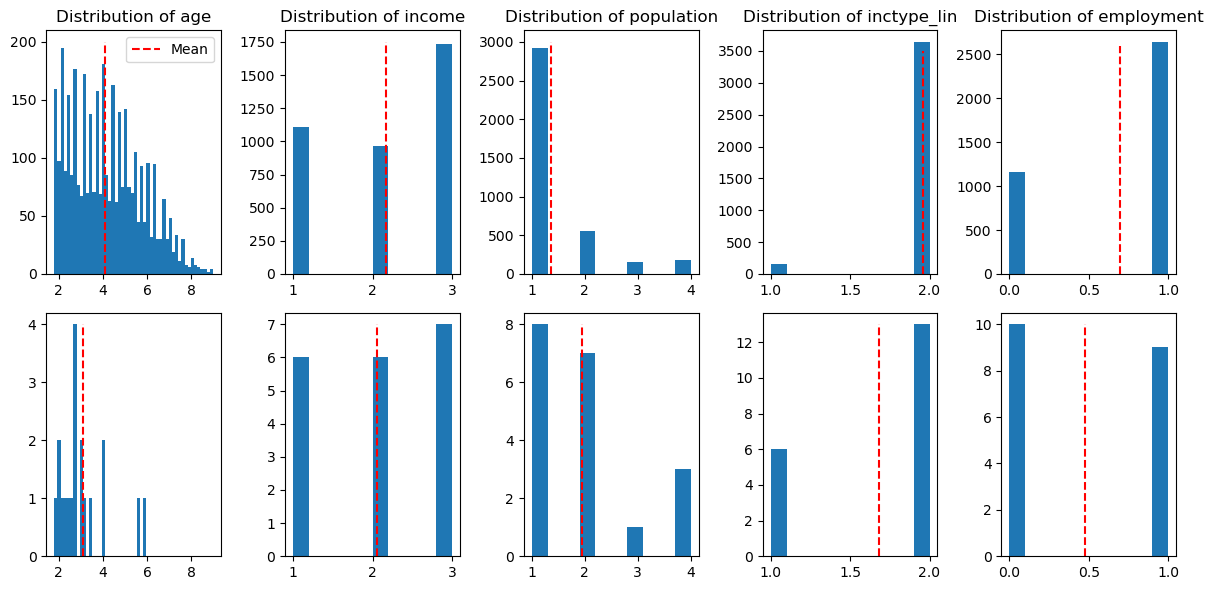

In [11]:
f, ax = plt.subplots(2, 5, figsize=(12, 6))

# extensive margin
ax[0,0].set_title('Distribution of age')
ax[0,0].hist(data['sage'], bins=50, range=[1.8, 9.0])
ax[0,0].vlines(data['sage'].mean(), 0, 200, colors='r', linestyles='dashed', label='Mean') # mean and median overlaps
ax[0,0].legend()

ax[0,1].set_title('Distribution of income')
ax[0,1].hist(data['sincome'])
ax[0,1].vlines(data['sincome'].mean(), 0, 1750, colors='r', linestyles='dashed')

ax[0,2].set_title('Distribution of population')
ax[0,2].hist(data['spop'])
ax[0,2].vlines(data['spop'].mean(), 0, 3000, colors='r', linestyles='dashed')

ax[0,3].set_title('Distribution of inctype_lin')
ax[0,3].hist(data['inctype_lin'])
ax[0,3].vlines(data['inctype_lin'].mean(), 0, 3500, colors='r', linestyles='dashed')

ax[0,4].set_title('Distribution of employment')
ax[0,4].hist(data['sempl'])
ax[0,4].vlines(data['sempl'].mean(), 0, 2600, colors='r', linestyles='dashed')

# intensive margin
ax[1,0].hist(data['sage'][data['anyuseofforce_coded'] == 1], bins=50, range=[1.8, 9.0])
ax[1,0].vlines(data['sage'][data['anyuseofforce_coded'] == 1].mean(), 0, 4, colors='r', linestyles='dashed')

ax[1,1].hist(data['sincome'][data['anyuseofforce_coded'] == 1])
ax[1,1].vlines(data['sincome'][data['anyuseofforce_coded'] == 1].mean(), 0, 7, colors='r', linestyles='dashed')

ax[1,2].hist(data['spop'][data['anyuseofforce_coded'] == 1])
ax[1,2].vlines(data['spop'][data['anyuseofforce_coded'] == 1].mean(), 0, 8, colors='r', linestyles='dashed')

ax[1,3].hist(data['inctype_lin'][data['anyuseofforce_coded'] == 1])
ax[1,3].vlines(data['inctype_lin'][data['anyuseofforce_coded'] == 1].mean(), 0, 13, colors='r', linestyles='dashed')

ax[1,4].hist(data['sempl'][data['anyuseofforce_coded'] == 1])
ax[1,4].vlines(data['sempl'][data['anyuseofforce_coded'] == 1].mean(), 0, 10, colors='r', linestyles='dashed')

f.tight_layout()
f.savefig('IntensivevsExtensiveMargin.png')

In [12]:
print(f'Intensive margin averages:')
print(f'sage:\t\t{data['sage'][data['anyuseofforce_coded'] == 1].mean():.2f}')
print(f'sincome:\t{data['sincome'][data['anyuseofforce_coded'] == 1].mean():.2f}')
print(f'spop:\t\t{data['spop'][data['anyuseofforce_coded'] == 1].mean():.2f}')
print(f'inctype_lin:\t{data['inctype_lin'][data['anyuseofforce_coded'] == 1].mean():.2f}')
print(f'sempl:\t\t{data['sempl'][data['anyuseofforce_coded'] == 1].mean():.2f}')

Intensive margin averages:
sage:		3.08
sincome:	2.05
spop:		1.95
inctype_lin:	1.68
sempl:		0.47


## Linear Probability Model (LPM)

In [13]:
ols_results =  lm.estimate(y, x, robust_se=True)
ols_tab = lm.print_table((y_label, x_labels), ols_results, title='LPM results')
ols_tab

LPM results
Dependent variable: anyuseofforce_coded

R2 = 0.031
sigma2 = nan


,b_hat,se,t
sblack,0.0067,0.0076,0.8799
shisp,0.0137,0.0088,1.5629
swhite,0.0044,0.0060,0.7273
smale,0.0048,0.0022,2.1556
sage,-0.0013,0.0006,-2.0825
sempl,-0.0053,0.0031,-1.6737
sincome,0.0017,0.0014,1.1998
spop,0.0050,0.0022,2.2966
daytime,-0.0017,0.0028,-0.6008
inctype_lin,-0.0165,0.0088,-1.8606


In [14]:
for alpha in [0.01, 0.05, 0.1]:
    print(f'{alpha} level of significance bears the critical value {norm.ppf(1-alpha/2):.2f}')

0.01 level of significance bears the critical value 2.58
0.05 level of significance bears the critical value 1.96
0.1 level of significance bears the critical value 1.64


## Probit

In [15]:
theta0 = probit.starting_values(y, x)
print(theta0)

[ 0.01663346  0.0343133   0.01093297  0.01209689 -0.00323519 -0.01314457
  0.00417925  0.01247935 -0.00428019 -0.04114283  0.0677402   0.09092308
  0.05604228]


In [16]:
ll = probit.loglikelihood(theta0, y, x)
ll

array([-0.70983251, -0.73620633, -0.72182501, ..., -0.68060296,
       -0.71655806, -0.68415684])

In [17]:
probit_results = est.estimate(probit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023126
         Iterations: 94
         Function evaluations: 1428
         Gradient evaluations: 102


In [18]:
probit_tab = est.print_table(x_labels, probit_results, title=f'Logit, y = {y_label}')
probit_tab

Optimizer succeeded after 94 iter. (1428 func. evals.). Final criterion:  0.02313.
Logit, y = anyuseofforce_coded


,theta,se,t
sblack,-0.1078,0.6129,-0.1759
shisp,0.1004,0.5975,0.1680
swhite,-0.3052,0.5413,-0.5637
smale,0.4630,0.3690,1.2547
sage,-0.1547,0.1458,-1.0606
sempl,-0.4223,0.2558,-1.6513
sincome,0.0241,0.1645,0.1467
spop,0.1715,0.1654,1.0366
daytime,-0.1330,0.2952,-0.4505
inctype_lin,-0.9137,0.3262,-2.8012


## Logit

In [19]:
theta0 = logit.starting_values(y, x)
theta0

array([ 0.02661353,  0.05490128,  0.01749275,  0.01935503, -0.00517631,
       -0.02103131,  0.0066868 ,  0.01996697, -0.00684831, -0.06582853,
        0.10838432,  0.14547692,  0.08966765])

In [20]:
logit_results = est.estimate(logit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023197
         Iterations: 130
         Function evaluations: 1848
         Gradient evaluations: 132


In [21]:
logit_tab = est.print_table(x_labels, logit_results, title=f'Logit, y = {y_label}')
logit_tab

Optimizer succeeded after 130 iter. (1848 func. evals.). Final criterion:   0.0232.
Logit, y = anyuseofforce_coded


,theta,se,t
sblack,-0.0859,1.4436,-0.0595
shisp,0.5083,1.3714,0.3706
swhite,-0.3755,1.2893,-0.2913
smale,0.9782,0.8015,1.2204
sage,-0.4061,0.3295,-1.2323
sempl,-0.9633,0.5677,-1.6968
sincome,0.0179,0.3586,0.0499
spop,0.4629,0.3508,1.3194
daytime,-0.3859,0.6727,-0.5736
inctype_lin,-1.8960,0.7248,-2.6159


## Partial effects: Functions

In [30]:
def current_and_next_value(df, var, value):

    # get unique values and sort
    uniques = np.sort(df[var].unique())

    # assert value is in range
    if value < uniques[0] or value > uniques[-1]:
        raise ValueError(f'Value {value} is out of range [{uniques[0]}, {uniques[-1]})')
    
    # find index of value and next value by going through list of uniques and flooring
    for i, i_v in enumerate(uniques):

        if i_v == value:
            indx = i
            break

        if i_v > value:
            indx = i - 1
            break

    indx_next = indx + 1

    return uniques[indx], uniques[indx_next]

def compute_simple_pe(x_old, x_new, theta_probit, theta_logit):

    # probit
    pe_probit = probit.predict(theta_probit, x_new) - probit.predict(theta_probit, x_old)

    # logit
    pe_logit = logit.predict(theta_logit, x_new) - logit.predict(theta_logit, x_old)

    return np.array([pe_probit, pe_logit])

In [34]:
def compute_all_pe(x_, x_labels, b_probit, b_logit, cov_probit, cov_logit, do_delta=True):

    pe_av = np.zeros((x_.shape[0], 2)) # one col for probit, one for logit
    pe_av_se = np.zeros((x_.shape[0], 2))

    for i, var in enumerate(x_labels):

        idx = x_labels.index(var)
        x_low = x_.copy()
        x_high = x_.copy()

        x_low[idx], x_high[idx] = current_and_next_value(data, var, x_[idx])

        pe_av[i,:] = compute_simple_pe(x_low, x_high, b_probit, b_logit)

        if do_delta:

            # probit
            g_probit = norm.pdf(x_high * b_probit)*x_high - norm.pdf(x_low * b_probit)*x_low
            se_probit = np.sqrt(g_probit.T @ cov_probit @ g_probit)

            # logit
            g = logit.predict(b_logit, x_high)*(1-logit.predict(b_logit, x_high))*x_high - logit.predict(b_logit, x_low)*(1 - logit.predict(b_logit, x_low))*x_low
            se_logit = np.sqrt(g.T @ cov_logit @ g)

            pe_av_se[i,:] =  np.array([se_probit, se_logit])

        else:
            pe_av_se[i,:] = np.array([np.nan, np.nan]) # nan out
    
    return pe_av, pe_av_se

In [36]:
b_lpm = ols_tab.b_hat.values
b_probit = probit_tab.theta.values
b_logit = logit_tab.theta.values

cov_lpm = ols_results.get('cov')
cov_probit = probit_results.get('cov')
cov_logit = logit_results.get('cov')

average_joe = x.mean(axis=0)

compute_all_pe(average_joe, x_labels, b_probit, b_logit, cov_probit, cov_logit, do_delta=True)

(array([[-2.84359679e-04, -1.10314935e-04],
        [ 3.42002408e-04,  8.34499470e-04],
        [-1.18360750e-03, -5.48309311e-04],
        [ 1.43606865e-03,  1.31196435e-03],
        [-4.52873651e-05, -5.28497172e-05],
        [-1.73437799e-03, -1.60245950e-03],
        [ 7.41012479e-05,  2.39032552e-05],
        [ 5.59059720e-04,  6.60457495e-04],
        [-4.29873732e-04, -5.49501498e-04],
        [-1.13895197e-02, -6.89584068e-03],
        [-4.81768190e-03, -3.32325887e-03],
        [ 1.44551358e-02,  1.19968328e-02],
        [-1.24457912e-03, -1.49496524e-03]]),
 array([[2.43084838e-01, 1.77729627e-03],
        [2.37152009e-01, 2.90397102e-03],
        [2.06123961e-01, 2.01779937e-03],
        [1.32247930e-01, 9.70188712e-04],
        [2.78308879e-03, 4.56365022e-05],
        [9.33262811e-02, 1.25882185e-03],
        [6.52626312e-02, 4.79265808e-04],
        [5.94206645e-02, 5.59164602e-04],
        [1.16749157e-01, 1.12441897e-03],
        [3.67147735e-02, 5.37911059e-03],
      

In [37]:
for col in data.columns:
    if col in x_labels:
        print(f'{col}:  {data[col].unique()}')

sblack:  [1 0]
shisp:  [0 1]
swhite:  [0 1]
smale:  [1 0]
sage:  [1.8 2.  2.2 2.9 2.8 2.6 2.5 3.  4.1 4.4 4.7 4.8 5.2 1.6 1.7 1.9 2.1 2.4
 2.3 2.7 3.1 3.2 3.3 3.4 3.5 3.9 3.7 3.6 4.  4.3 4.2 4.6 4.5 5.3 5.  5.1
 5.4 5.9 5.7 5.8 5.5 5.6 6.1 6.  6.3 6.4 6.2 6.9 6.8 6.6 7.1 7.2 9.  7.8
 8.3 3.8 4.9 6.5 7.  7.3 7.4 8.5 7.7 8.1 8.  7.6 6.7 7.9 8.6 7.5 8.4 8.2
 8.8 8.9]
sempl:  [0 1]
sincome:  [1 2 3]
spop:  [1 4 3 2]
daytime:  [1 0]
inctype_lin:  [2 1]
omajwhite:  [1 0]
sbehavior:  [0 1]
omajblackhisp:  [0 1]


General decisions:

$\texttt{omajblackhisp}=0$

$\texttt{omajwhite}=1$

$\texttt{sage}=3.08$

$\texttt{sincome}=2.05$

$\texttt{pop}=1.95$

$\texttt{inctype\_lin}=1.68$

$\texttt{sempl}=0.47$

## Bootstrapping

In [28]:
def bootstrap_sample(y, x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: 1-dimensional N-array
        x: (N,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: N-array
            x_i: (N,K) matrix 
    '''
    N = y.size

    ii_boot = np.random.choice(N, size=N, replace=True) # indices of the bootstrap sample

    y_i = y[ii_boot] # selection of N rows from y 
    x_i = x[ii_boot] # selection of N rows from x 
    
    return y_i, x_i 

In [38]:
#pd.read_csv('naive_bootstrap_results.csv', index_col=0) # dont use as average_joe changes according to sample each time

In [39]:
#pd.read_csv('samex_bootstrap_results.csv', index_col=0)[['Probit: PEA', 'Probit: PEA SE', 'Logit PEA', 'Logit: PEA SE']]

In [ ]:
special_joe = np.array([np.nan, # sblack
                        np.nan, # shisp
                        np.nan, # swhite
                        np.nan, # smale
                        3.08, # sage
                        0.47, # sempl
                        2.05, # sincome
                        1.95, # spop
                        np.nan, # daytime
                        1.68, # inctype_lin
                        1.0, # omajwhite
                        np.nan, # sbehavior
                        0.0 # omajblackhisp
                        ])

In [ ]:
def compute_special_pes(spec_joe, b_probit, b_logit):
    results = np.zeros((8,3,2)) + np.nan

    # outer loop over specifications: 2^3 = 8
    i = 0 # counter
    for smale in [0, 1]:
        for daytime in [0, 1]:
            for sbehavior in [0, 1]:

                special_joe_i = spec_joe.copy()

                special_joe_i[x_labels.index('smale')] = smale
                special_joe_i[x_labels.index('daytime')] = daytime
                special_joe_i[x_labels.index('sbehavior')] = sbehavior

                # inner loop over races: 3 -> #operations = 8*3 = 24

                # 1st case: white to black
                joe_1st_pre = special_joe_i.copy()
                joe_1st_post = special_joe_i.copy()

                joe_1st_pre[x_labels.index('shisp')], joe_1st_post[x_labels.index('shisp')] = 0,0

                joe_1st_pre[x_labels.index('swhite')] = 1.0
                joe_1st_pre[x_labels.index('sblack')] = 0.0

                joe_1st_post[x_labels.index('swhite')] = 0.0
                joe_1st_post[x_labels.index('sblack')] = 1.0

                results[i,0,:] = compute_simple_pe(joe_1st_pre, joe_1st_post, b_probit, b_logit)

                # 2nd case: white to hisp
                joe_2nd_pre = special_joe_i.copy()
                joe_2nd_post = special_joe_i.copy()

                joe_2nd_pre[x_labels.index('sblack')], joe_2nd_post[x_labels.index('sblack')] = 0,0

                joe_2nd_pre[x_labels.index('swhite')] = 1.0
                joe_2nd_pre[x_labels.index('shisp')] = 0.0

                joe_2nd_post[x_labels.index('swhite')] = 0.0
                joe_2nd_post[x_labels.index('shisp')] = 1.0

                results[i,1,:] = compute_simple_pe(joe_2nd_pre, joe_2nd_post, b_probit, b_logit)

                # 3rd case: white to other
                joe_3rd_pre = special_joe_i.copy()
                joe_3rd_post = special_joe_i.copy()

                joe_3rd_pre[x_labels.index('shisp')], joe_3rd_post[x_labels.index('shisp')] = 0,0
                joe_3rd_pre[x_labels.index('sblack')], joe_3rd_post[x_labels.index('sblack')] = 0,0

                joe_3rd_pre[x_labels.index('swhite')] = 1.0

                joe_3rd_post[x_labels.index('swhite')] = 0.0

                results[i,2,:] = compute_simple_pe(joe_3rd_pre, joe_3rd_post, b_probit, b_logit)

                # update counter
                i += 1

    return results

In [ ]:
nboot = 1000  # Number of bootstraps, should ideally be very large 

# Set seed for random sampling.
seed = 42
rng = np.random.seed(seed)

# initialize 
special_pes_boot = np.zeros((nboot, 8, 3, 2))
av_pe_boot = np.zeros((nboot, x.shape[1], 2)) + np.nan # 2 models: probit, logit
b_probit_boot = np.zeros((nboot, x.shape[1])) + np.nan
b_logit_boot = np.zeros((nboot, x.shape[1])) + np.nan

for i in range(nboot): 
    print(f'Bootstrap iteration {i+1}/{nboot}')
    
    # 1. choose which individuals to draw
    y_i, x_i = bootstrap_sample(y, x) # Fill in: call the bootstrap sample function 

    # 2. estimate and compute 
    theta0 = probit.starting_values(y_i, x_i)
    probit_results = est.estimate(probit.q, theta0, y_i, x_i, options={'disp': False}, cov_type=None)

    theta0 = logit.starting_values(y_i, x_i)
    logit_results = est.estimate(logit.q, theta0, y_i, x_i, options={'disp': False}, cov_type=None)

    # 2. save coefs
    b_probit_boot[i, :] = probit_results['theta']
    b_logit_boot[i, :] = logit_results['theta']

    # 3. save pe on the average
    av_pe_boot[i, :, :] = compute_all_pe(average_joe, x_labels, b_probit, b_logit, None, None, do_delta=False)

    # 4. compute selected PEs
    special_pes_boot[i,:,:,:] = compute_special_pes(special_joe, b_probit, b_logit)  

Bootstrap iteration 1/1000
Bootstrap iteration 2/1000
Bootstrap iteration 3/1000


KeyboardInterrupt: 

In [43]:
old_results = np.load('results_bootstrap.npy')

In [44]:
pe_1st_case = pd.DataFrame(old_results.mean(axis=0)[:,0,:], columns=['probit', 'logit'])
pe_2nd_case = pd.DataFrame(old_results.mean(axis=0)[:,1,:], columns=['probit', 'logit'])
pe_3rd_case = pd.DataFrame(old_results.mean(axis=0)[:,2,:], columns=['probit', 'logit'])

print(f'PE for 1st case:\n{pe_1st_case}\n')
print(f'PE for 2nd case:\n{pe_2nd_case}\n')
print(f'PE for 3rd case:\n{pe_3rd_case}\n')

PE for 1st case:
     probit     logit
0  0.002164  0.001468
1  0.015613  0.008977
2  0.001688  0.001243
3  0.014117  0.009004
4  0.006921  0.004494
5  0.029398  0.022217
6  0.005894  0.004021
7  0.028092  0.022961

PE for 2nd case:
     probit     logit
0  0.005674  0.004589
1  0.047077  0.046018
2  0.003506  0.002824
3  0.034891  0.029214
4  0.017592  0.013280
5  0.086694  0.099627
6  0.012266  0.008767
7  0.070764  0.071579

PE for 3rd case:
     probit     logit
0  0.004227  0.002306
1  0.028626  0.016155
2  0.002392  0.001244
3  0.019835  0.008736
4  0.012476  0.006253
5  0.051496  0.032627
6  0.008281  0.003836
7  0.040281  0.021192



In [46]:
pe_1st_case_se = pd.DataFrame(old_results.std(axis=0)[:,0,:], columns=['probit', 'logit'])
pe_2nd_case_se = pd.DataFrame(old_results.std(axis=0)[:,1,:], columns=['probit', 'logit'])
pe_3rd_case_se = pd.DataFrame(old_results.std(axis=0)[:,2,:], columns=['probit', 'logit'])

print(f'PE se for 1st case:\n{pe_1st_case_se}\n')
print(f'PE se for 2nd case:\n{pe_2nd_case_se}\n')
print(f'PE se for 3rd case:\n{pe_3rd_case_se}\n')

PE se for 1st case:
     probit     logit
0  0.004217  0.003834
1  0.043337  0.047238
2  0.003069  0.002827
3  0.033610  0.033252
4  0.012332  0.010201
5  0.077010  0.090537
6  0.010062  0.008502
7  0.063632  0.071494

PE se for 2nd case:
     probit     logit
0  0.006112  0.005250
1  0.043466  0.050166
2  0.003458  0.002967
3  0.031037  0.029565
4  0.016769  0.014774
5  0.072087  0.094611
6  0.011660  0.009889
7  0.058466  0.069055

PE se for 3rd case:
     probit     logit
0  0.006594  0.005150
1  0.050068  0.054556
2  0.003501  0.002568
3  0.034335  0.029893
4  0.017092  0.012673
5  0.084302  0.098953
6  0.011740  0.007886
7  0.066419  0.066204



In [47]:
i = 0
for smale in [0, 1]:
    for daytime in [0, 1]:
        for sbehavior in [0, 1]:
            print(f'row {i}:\t\tsmale={smale}, daytime={daytime}, sbehavior={sbehavior}')
            i += 1

row 0:		smale=0, daytime=0, sbehavior=0
row 1:		smale=0, daytime=0, sbehavior=1
row 2:		smale=0, daytime=1, sbehavior=0
row 3:		smale=0, daytime=1, sbehavior=1
row 4:		smale=1, daytime=0, sbehavior=0
row 5:		smale=1, daytime=0, sbehavior=1
row 6:		smale=1, daytime=1, sbehavior=0
row 7:		smale=1, daytime=1, sbehavior=1


In [48]:
samex_bootstrap = pd.DataFrame({''
              #'LPM: Coefs':b_ols_boot.mean(axis=0),
              #'LPM: SE':b_ols_boot.std(axis=0),
              'Probit: Coefs': b_probit_boot.mean(axis=0),
              'Probit: SE': b_probit_boot.std(axis=0),
              'Logit: Coefs': b_logit_boot.mean(axis=0),
              'Logit: SE': b_logit_boot.std(axis=0),
              #'LMP: PEA': pe_av_boot[:, :, 0].mean(axis=0),
              #'LMP: PEA SE': pe_av_boot[:, :, 0].std(axis=0),
              'Probit: PEA': pe_av_boot[:, :, 1].mean(axis=0),
              'Probit: PEA SE': pe_av_boot[:, :, 1].std(axis=0),
              'Logit PEA': pe_av_boot[:, :, 2].mean(axis=0),
              'Logit: PEA SE': pe_av_boot[:, :, 2].std(axis=0)},
              index=x_labels)

samex_bootstrap.to_csv('samex_bootstrap_results.csv')

NameError: name 'b_probit_boot' is not defined